In [94]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
##  download pretrained word vectors of news

## api.load('word2vec-google-news-300')

In [3]:
df = pd.read_csv('spam.csv',sep=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Keep necessary columns only
df = df[['v1','v2']]

# Renaming columns
df.columns = ['label','sms']
##df = df.set_axis(['label','sms'], axis=1)

# Shape of dataframe
print(df.shape)

# Null values
print('Null Values in the dataframe:',df.isnull().sum().sum())
print('\n Null Values by columns:')
print(df.isna().sum())

(5572, 2)
Null Values in the dataframe: 0

 Null Values by columns:
label    0
sms      0
dtype: int64


In [13]:
df.to_csv('spam_req_features.csv',index=False)

In [7]:
## Target column Distribution
label_count = df.label.value_counts()
print('Target Column Distribution:')
print(label_count)

label_percent = df.label.value_counts(normalize=True)*100
print('\nTarget Column Distribution[--percent--]:')
print(label_percent)

# Balance check              we will keep threshold upto 60%
if label_percent.get('ham',0)>60:
    print("\nImbalance Classes in Dataframe")
else:
    print("Balanced Dataframe")


Target Column Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Target Column Distribution[--percent--]:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

Imbalance Classes in Dataframe


In [9]:
import string
import contractions
import re
import nltk
nltk.download('stopwords')  # if not
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
## Text Preprocessing Function

def clean_text(text):
    """ This function will do complete preproceesing of the text and provide clean_text
        lowercasing, special character, numbers, contraction, stopwords etc."""
    # Lowercasing
    text = text.lower()

    # HTML Tags (if any)
    text = re.sub(r"<.*?>","", text)
    
    # Url's and digits
    text = re.sub(r"https?://\S+|www\.\S+|[\d]+","", text)

    # contractions word like im --> i am
    text = contractions.fix(text)

    # Punctuations
    text = text.translate(str.maketrans("","",string.punctuation))

    # Split text
    words = text.split()
    
    # Stopwords
    eng_words = stopwords.words('english')
    words = [lemmatizer.lemmatize(word) for word in words if word not in eng_words]
    return " ".join(words)

In [13]:
df1 = df.copy()

In [15]:
df1['sms_legth'] = df1.sms.apply(len)

In [17]:
df1['cleaned_sms'] = df1.sms.apply(clean_text)

In [19]:
df1

,label,sms,sms_legth,cleaned_sms
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think go usf life around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,nd time tried contact å£ pound prize claim eas...
5568,ham,Will Ì_ b going to esplanade fr home?,37,ì b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,125,guy bitching acted like would interested buyin...


In [21]:
# Encoding target column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1['label'] = le.fit_transform(df1['label'])
df1.head()

,label,sms,sms_legth,cleaned_sms
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think go usf life around though


In [55]:
# Tokens for word2vec
from nltk import word_tokenize
corpus = df1['cleaned_sms'].apply(word_tokenize)

In [57]:
# train test split
X = corpus
y = df1['label']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Word2Vec model using Gensim

In [59]:
X_train

1978           [boat, still, mom, check, yo, half, naked]
3989    [bank, granite, issue, strongbuy, explosive, p...
3935           [r, giving, second, chance, rahul, dengra]
4078             [played, smash, bros, ltgt, religiously]
4086    [private, account, statement, show, unredeemed...
                              ...                        
3772    [came, hostel, going, sleep, plz, call, class,...
5191                                 [sorry, call, later]
5226               [prabhai, sorydarealyfrm, heart, sory]
5390                        [nt, joking, seriously, told]
860                                    [work, going, min]
Name: cleaned_sms, Length: 4457, dtype: object

In [61]:
from gensim.models import Word2Vec, KeyedVectors
spam_model = Word2Vec(sentences=X_train,    # Building voabulary from train
                      vector_size=100, window=5, min_count=2, workers=4, sg=1)

In [67]:
## Training Word2Vec model
spam_model.train(X_train, total_examples=spam_model.corpus_count, epochs=10)

(307537, 373310)

In [81]:
spam_model.wv.most_similar('girl')

[('knw', 0.9222782850265503),
 ('hello', 0.8974279761314392),
 ('meaning', 0.891961395740509),
 ('margaret', 0.8883962035179138),
 ('wt', 0.877517819404602),
 ('girlfrnd', 0.8745303153991699),
 ('name', 0.8484283685684204),
 ('frnd', 0.8445254564285278),
 ('joined', 0.8321678042411804),
 ('grahmbell', 0.8076561689376831)]

### Defining avgWord2Vec

In [88]:
def avg_word2vec(sentences,model):
    vectors = [model.wv[word] for word in sentences if word in model.wv]

    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [117]:
from tqdm import tqdm
import time

X_train_vector = np.array([avg_word2vec(s,spam_model) for s in tqdm(X_train, desc='Vectorizing X Train')])

Vectorizing X Train: 100%|██████████████████████████████████████████████████████| 4457/4457 [00:00<00:00, 21744.66it/s]


In [119]:
X_train_vector.shape

(4457, 100)

In [121]:
X_test_vector = np.array([avg_word2vec(s,spam_model) for s in tqdm(X_test, desc='Vectorizing X Test')])

Vectorizing X Test: 100%|███████████████████████████████████████████████████████| 1115/1115 [00:00<00:00, 22746.35it/s]


In [123]:
X_test_vector.shape

(1115, 100)

## Model Building

- **Logistic Regression**
- **Decision Tree**
- **Random Forest**
- **Support Vector Machine**
- **KNN**
- **Naive Bayes**
- **XG Boost**
- ****

In [107]:
# Libraries 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix

In [125]:
# Testing diff. Classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'XG Boost': XGBClassifier()
}

for name,model in models.items():
    model.fit(X_train_vector,y_train)
    cv_score = cross_val_score(model, X_train_vector,y_train,scoring='accuracy',cv=10)
    print(f"{name}: {cv_score.mean()}")

Logistic Regression: 0.9692603416133421
Decision Tree: 0.958266236710838
Random Forest: 0.9793560739658387
SVM: 0.9741955963117851
KNN: 0.9723983473572833
XG Boost: 0.9800282158512621


In [129]:
## Evaluation of models
report = []

for name,model in models.items():
    train_pred = model.predict(X_train_vector)
    test_pred = model.predict(X_test_vector)
    train_acc = accuracy_score(y_train,train_pred)
    test_acc = accuracy_score(y_test,test_pred)
    ps = precision_score(y_test,test_pred)
    rs = recall_score(y_test,test_pred)
    f1 = f1_score(y_test,test_pred)
    cr = classification_report(y_test,test_pred)
    cm = confusion_matrix(y_test,test_pred)

    print(name)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    print('============================================================================')
    report.append({'Model': name, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc, 'Recall': rs, 'Precision': ps, 'F1': f1})

report_df = pd.DataFrame(data=report, index=None)

Logistic Regression
Confusion Matrix:
 [[949  16]
 [ 27 123]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       965
           1       0.88      0.82      0.85       150

    accuracy                           0.96      1115
   macro avg       0.93      0.90      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Decision Tree
Confusion Matrix:
 [[941  24]
 [ 20 130]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       965
           1       0.84      0.87      0.86       150

    accuracy                           0.96      1115
   macro avg       0.91      0.92      0.92      1115
weighted avg       0.96      0.96      0.96      1115

Random Forest
Confusion Matrix:
 [[957   8]
 [ 20 130]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99  

In [131]:
report_df.sort_values(by=['Test Accuracy','Train Accuracy','Precision'],ascending=False)

,Model,Train Accuracy,Test Accuracy,Recall,Precision,F1
2,Random Forest,0.999776,0.974888,0.866667,0.942029,0.902778
5,XG Boost,0.999776,0.973991,0.886667,0.917241,0.901695
4,KNN,0.981153,0.973991,0.886667,0.917241,0.901695
3,SVM,0.976666,0.963229,0.833333,0.886525,0.859107
0,Logistic Regression,0.971057,0.961435,0.820000,0.884892,0.851211
1,Decision Tree,0.999776,0.960538,0.866667,0.844156,0.855263


<Axes: >

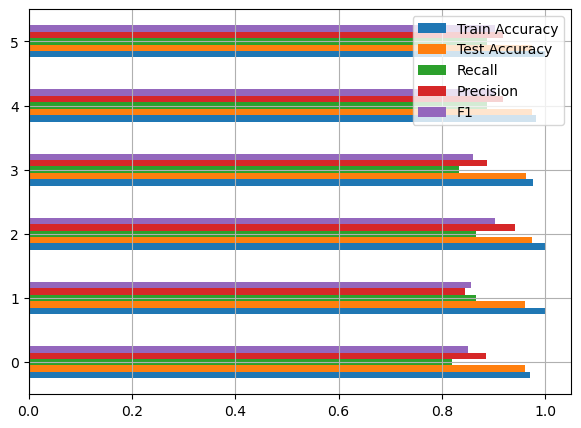

In [149]:
report_df.plot(kind='barh',grid=True, figsize=(7,5))

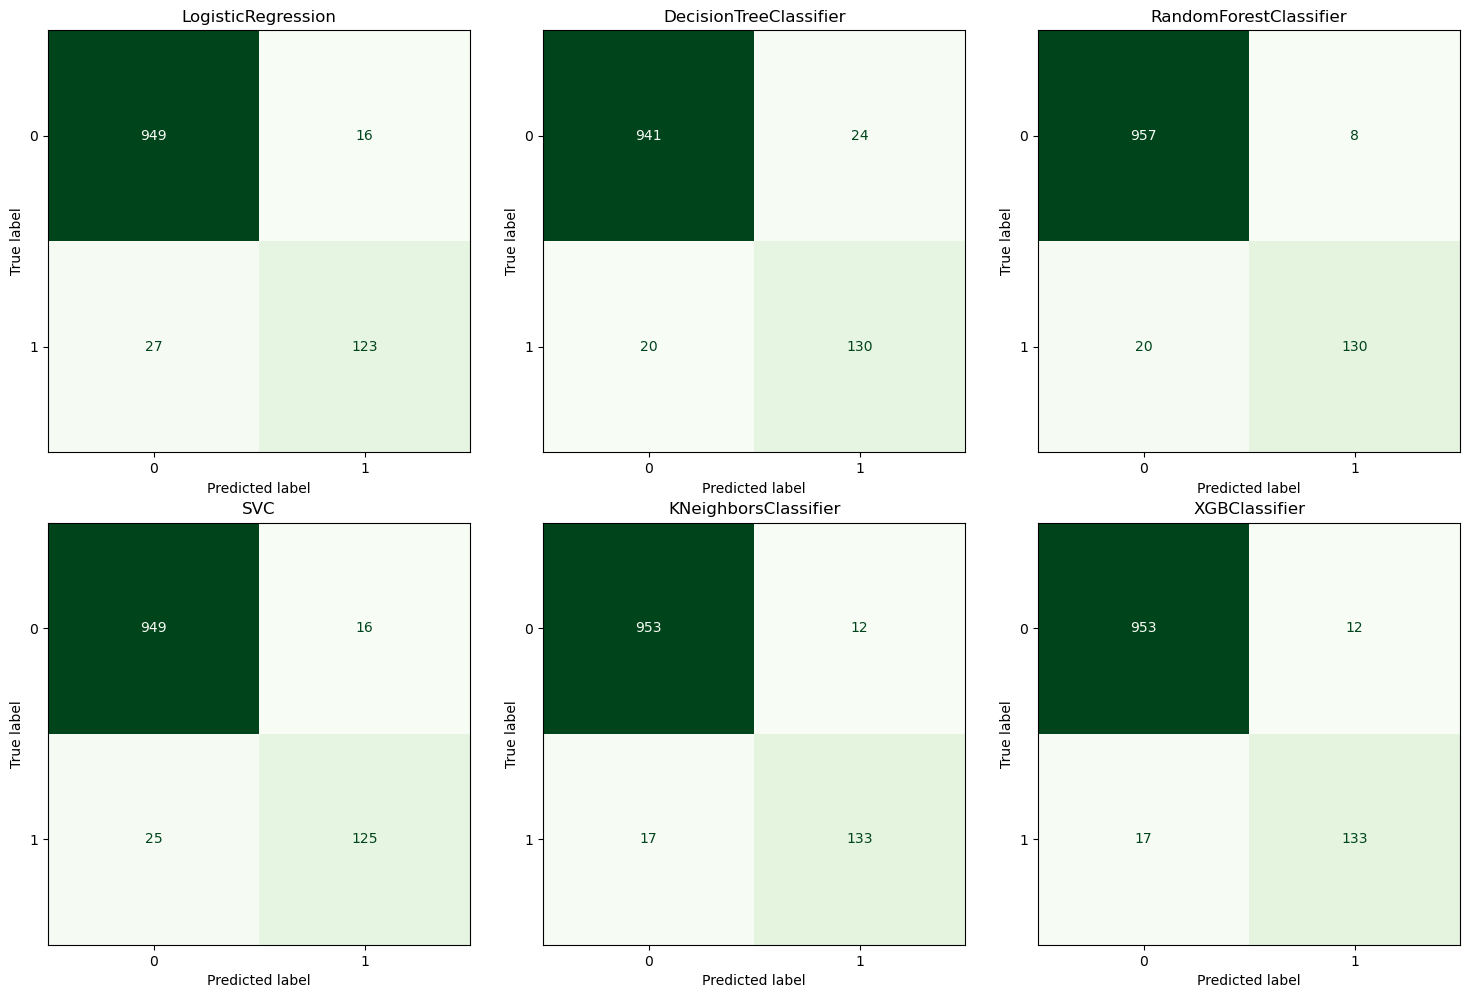

In [143]:
from sklearn.metrics import ConfusionMatrixDisplay
fig,axes = plt.subplots(2,3,figsize=(15,10))
axes=axes.flatten()

for model, ax in zip(models.values(), axes):
    disp = ConfusionMatrixDisplay.from_estimator(model,X_test_vector,y_test,ax=ax,cmap='Greens',colorbar=False)
    ax.set_title(type(model).__name__)

plt.tight_layout()
plt.show()